# Lab 12

107062566 黃鈺程


## Requirement

latest tensorflow, tqdm, pillow, matplotlib

I use eager execution as latest tensorflow is necessary.

In [1]:
import json
from pathlib import Path

import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm

tfe = tf.contrib.eager
tf.enable_eager_execution()

## 1. Prepare CIFAR 10

Samples from `*.bin` is extracted and saved as images on disks.
And the labels, path to image are store in a json file.

```
data/
    train/
        000000.jpg
        000001.jpg
        ...
        ann.json
    valid/
        000000.jpg
        000001.jpg
        ...
        ann.json
```

From my experiences, I believe this this the best practice except you can load all data in memory.

In [2]:
def prepare_cifar(src_dir, dst_dir, n_train=50_000):
    src_dir = Path(src_dir)
    bin_paths = sorted(list(src_dir.glob('*.bin')))
    dst_dir = Path(dst_dir)
    train_dir = dst_dir / 'train'
    valid_dir = dst_dir / 'valid'
    for dir_ in [train_dir, valid_dir]:
        dir_.mkdir(exist_ok=True, parents=True)

    train_anns = []
    valid_anns = []

    def process_img_lbl(img, lbl):
        if len(train_anns) >= n_train:
            img_path = valid_dir / f'{len(valid_anns):06d}.jpg'
            img_path = img_path.resolve().absolute()
            Image.fromarray(img).save(img_path, quality=100)
            valid_anns.append({'img_path': str(img_path), 'label': int(lbl)})
        else:
            img_path = train_dir / f'{len(train_anns):06d}.jpg'
            img_path = img_path.resolve().absolute()
            Image.fromarray(img).save(img_path, quality=100)
            train_anns.append({'img_path': str(img_path), 'label': int(lbl)})

    for bin_path in tqdm(bin_paths, desc='Prepare'):
        data = np.fromfile(str(bin_path), dtype=np.uint8)
        data = data.reshape(10_000, 3073)
        lbls = data[:, 0]
        imgs = data[:, 1:].reshape(-1, 3, 32, 32)
        imgs = imgs.transpose(0, 2, 3, 1)
        for img, lbl in zip(imgs, lbls):
            process_img_lbl(img, lbl)

    with (train_dir / 'ann.json').open('w') as f:
        json.dump(train_anns, f, indent=2, ensure_ascii=False)
    with (valid_dir / 'ann.json').open('w') as f:
        json.dump(valid_anns, f, indent=2, ensure_ascii=False)

In [3]:
## run 1 time
# src_dir = './data/cifar-10-batches-bin/'
# dst_dir = './data/cifar10/'
# prepare_cifar(src_dir, dst_dir)

## 2. Load CIFAR 10 as Dataset

By utilizing `tf.contrib.py_func` and `tf.data.Dataset.map`, I can load samples multi-threaded.

In [4]:
def py_func_decorator(output_types=None,
                      output_shapes=None,
                      stateful=True,
                      name=None):
    def decorator(func):
        def call(*args, **kwargs):
            return tf.contrib.framework.py_func(
                func=func,
                args=args,
                kwargs=kwargs,
                output_types=output_types,
                output_shapes=output_shapes,
                stateful=stateful,
                name=name)

        return call

    return decorator

def get_item(anns, idx, size):
    ann = anns[idx]
    img = Image.open(ann['img_path'])
    img = img.resize(size)
    img = np.float32(img) / 255
    lbl = tf.keras.utils.to_categorical(ann['label'], 10)
    return img, lbl

In [5]:
with open('./data/cifar10/train/ann.json') as f:
    train_anns = json.load(f)
with open('./data/cifar10/valid/ann.json') as f:
    valid_anns = json.load(f)


@py_func_decorator(
    output_types=(tf.float32, tf.float32), output_shapes=([32, 32, 3], [10]))
def load_train(idx):
    return get_item(train_anns, idx, [32, 32])


@py_func_decorator(
    output_types=(tf.float32, tf.float32), output_shapes=([32, 32, 3], [10]))
def load_valid(idx):
    return get_item(valid_anns, idx, [32, 32])


n_train = len(train_anns) // 256 * 256
train_set = tf.data.Dataset.range(n_train)
train_set = train_set.map(load_train, num_parallel_calls=1)
train_set = train_set.prefetch(512).batch(256)

n_valid = len(valid_anns) // 256 * 256
valid_set = tf.data.Dataset.range(n_valid)
valid_set = valid_set.map(load_valid, num_parallel_calls=1)
valid_set = valid_set.prefetch(512).batch(256)

## Build Model and Training

I use `model.train_on_batch` and `model.test_on_batch` to train and evaluation model respectively.
Model is a small CNN optimized by `Adam(lr=1e-3)`
Keras is more convenient than tensorflow, especially in eager execution mode.

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, [3, 3], padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D([2, 2], strides=2),
    tf.keras.layers.Conv2D(64, [3, 3], padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D([2, 2], strides=2),
    tf.keras.layers.Conv2D(128, [3, 3], padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D([2, 2], strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])

optim = tf.train.AdamOptimizer(learning_rate=1e-3)
model.compile(
    loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [7]:
%%time

history = []

for epoch in range(10):
    print('Epoch', epoch, flush=True)
    history.append({
        'epoch': epoch,
        'train_loss': tfe.metrics.Mean(),
        'valid_loss': tfe.metrics.Mean(),
        'train_acc': tfe.metrics.Mean(),
        'valid_acc': tfe.metrics.Mean()
    })

    pbar = tqdm(total=n_train, desc='  Train', ascii=True)
    for img_batch, lbl_batch in train_set:
        img_batch, lbl_batch = np.float32(img_batch), np.float32(lbl_batch)
        loss, acc = model.train_on_batch(img_batch, lbl_batch)
        history[-1]['train_loss'](loss)
        history[-1]['train_acc'](acc)
        pbar.update(img_batch.shape[0])
        pbar.set_postfix({
            'loss': f'{history[-1]["train_loss"].result():.3f}',
            'acc': f'{history[-1]["train_acc"].result():.3f}'
        })
    pbar.close()

    metrics = {
        'loss': tfe.metrics.Mean(),
        'acc': tfe.metrics.Mean(),
    }
    pbar = tqdm(total=n_valid, desc='  Valid', ascii=True)
    for img_batch, lbl_batch in valid_set:
        img_batch, lbl_batch = np.float32(img_batch), np.float32(lbl_batch)
        loss, acc = model.test_on_batch(img_batch, lbl_batch)
        history[-1]['valid_loss'](loss)
        history[-1]['valid_acc'](acc)
        pbar.update(img_batch.shape[0])
        pbar.set_postfix({
            'loss': f'{history[-1]["valid_loss"].result():.3f}',
            'acc': f'{history[-1]["valid_acc"].result():.3f}'
        })
    pbar.close()

Epoch 0


  Valid: 100%|##########| 9984/9984 [00:02<00:00, 4155.77it/s, loss=1.378, acc=0.518]

Epoch 1



  Valid: 100%|##########| 9984/9984 [00:02<00:00, 3817.58it/s, loss=1.201, acc=0.576]

Epoch 2



  Valid: 100%|##########| 9984/9984 [00:02<00:00, 4007.77it/s, loss=1.068, acc=0.629]

Epoch 3



  Valid: 100%|##########| 9984/9984 [00:02<00:00, 3872.54it/s, loss=1.012, acc=0.648]

Epoch 4



  Valid: 100%|##########| 9984/9984 [00:03<00:00, 3255.71it/s, loss=0.955, acc=0.668]

Epoch 5



  Valid: 100%|##########| 9984/9984 [00:02<00:00, 3759.47it/s, loss=0.909, acc=0.688]

Epoch 6



  Valid: 100%|##########| 9984/9984 [00:02<00:00, 3959.97it/s, loss=0.892, acc=0.692]

Epoch 7



  Valid: 100%|##########| 9984/9984 [00:02<00:00, 3735.07it/s, loss=0.880, acc=0.698]

Epoch 8



  Valid: 100%|##########| 9984/9984 [00:02<00:00, 3740.19it/s, loss=0.848, acc=0.710]

Epoch 9



  Valid: 100%|##########| 9984/9984 [00:02<00:00, 3950.31it/s, loss=0.824, acc=0.717]

CPU times: user 11min 5s, sys: 21.4 s, total: 11min 26s
Wall time: 2min 43s


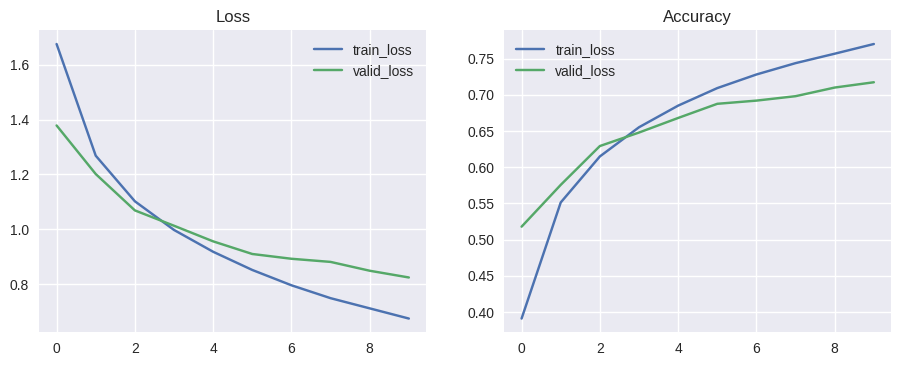

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

xs = np.arange(len(history))
fig, ax = plt.subplots(1, 2, dpi=100, figsize=(11, 4))
ax[0].plot(xs, [float(item['train_loss'].result()) for item in history], '-', label='train_loss')
ax[0].plot(xs, [float(item['valid_loss'].result()) for item in history], '-', label='valid_loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[1].plot(xs, [float(item['train_acc'].result()) for item in history], '-', label='train_loss')
ax[1].plot(xs, [float(item['valid_acc'].result()) for item in history], '-', label='valid_loss')
ax[1].legend()
ax[1].set_title('Accuracy')
plt.show()